In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
import shutil
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("PyTorch version", torch.__version__)

PyTorch version 1.7.0


In [3]:
# Hyperparameters
size = (128,128)
batch_size = 64
learning_rate = 1e-2
epochs = 8

training_folder_name = '../input/natural-images/data/natural_images' # name of the folder that contains the dataset with images of different dimensions
classes = sorted(os.listdir(training_folder_name))
print(classes)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


### Preprocessing
We will read in our image, and resize it and put it into a new folder, so that we can read it with torchvision.

In [4]:
# Function that resizes all images in datasets
def resize_image(src_image : str, size : tuple = (128,128)) -> np.ndarray: 
    # Convert color to RGB and then resizes it to the given size.
    img = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    return img

In [5]:
train_folder = '../working/data/natural_images' # name of the folder that contains the new dataset with images of the same dimensions

# if the new folder's path exists, we want to delete the path
if os.path.exists(train_folder):
    shutil.rmtree(train_folder)

In [6]:
# TODO: If we need to preprocess a bunch of files, we can use a ThreadPoolExecutor from concurrent.futures.ThreadPoolExecutor()
for root, folders, file in os.walk(training_folder_name):
    # Loop through all subfolders
    for sub_folder in folders:
        saveFolder = os.path.join(train_folder,sub_folder)
        if not os.path.exists(saveFolder):
            os.makedirs(saveFolder)
        # Loop through the images in subfolder
        file_names = os.listdir(os.path.join(root,sub_folder))
        for file_name in file_names:
            # Open the file and create a resized version and save it
            file_path = os.path.join(root,sub_folder, file_name)
            image = cv2.imread(file_path)
            resized_image = resize_image(image, size)
            saveAs = os.path.join(saveFolder, file_name)
            cv2.imwrite(saveAs, resized_image)
        print(f"Processed subfolder {sub_folder}")

print('Done')

Processed subfolder motorbike
Processed subfolder airplane
Processed subfolder flower
Processed subfolder dog
Processed subfolder fruit
Processed subfolder car
Processed subfolder cat
Processed subfolder person
Done


In [7]:
# Check if everything is preprocessed properly (by checking if the dimensions of the images are 128x128)
print("Original:", cv2.imread("../input/natural-images/natural_images/fruit/fruit_0000.jpg").shape)
print("Preprocessed:", cv2.imread("../working/data/natural_images/fruit/fruit_0000.jpg").shape)

Original: (100, 100, 3)
Preprocessed: (128, 128, 3)


In [8]:
# Data augmentations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create the full dataset
full_dataset = torchvision.datasets.ImageFolder(
    root=train_folder,
    transform=transform
)

# Split the dataset into train and test sets
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    
# Create data loaders 
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=0, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=0, shuffle=False)

print("Data loaders ready to be used!")

Data loaders ready to be used!


### Architecture
We will be creating a simple convnet with dropout in order to prevent overfitting.

In [9]:
# Create CNN
class CNN(nn.Module):
    def __init__(self, num_classes : int) -> None:
        super(CNN, self).__init__()        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=12, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.drop = nn.Dropout2d(p=0.2) 
        self.fc = nn.Linear(in_features=32 * 32 * 24, out_features=num_classes)

    def forward(self, x : torch.tensor) -> torch.tensor:        
        x = F.relu(self.pool(self.conv1(x))) # [128, 128, 3] -> [128, 128, 12] -> [64, 64, 12]
        x = F.relu(self.pool(self.conv2(x)))  # [64, 64, 12] -> [64, 64, 24] -> [32, 32, 24]
        
        x = F.dropout(self.drop(x), training=self.training) 
        
        x = x.view(-1, 32 * 32 * 24) # [32, 32, 24] -> [1, 1, 24576]
        x = self.fc(x) # [1, 1, 24576] -> [1, 1, 8]
        x = torch.log_softmax(x, dim=1)
        return x

In [10]:
# Create the model
model = CNN(num_classes=len(classes))
model.to(device)

CNN(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (drop): Dropout2d(p=0.2, inplace=False)
  (fc): Linear(in_features=24576, out_features=8, bias=True)
)

In [11]:
# Tests the model on the test loader
def test(model : torch.nn.Module, device : torch.device, test_loader : torch.utils.data.dataloader.DataLoader) -> None:
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        batch_count = 0
        for data, target in test_loader:
            batch_count += 1
            data, target = data.to(device), target.to(device)
            output = model(data)
            
            # Calculate the loss for this batch
            test_loss += loss_criteria(output, target).item()
            
            # Calculate the accuracy for this batch
            _, predicted = torch.max(output.data, 1)
            correct += torch.sum(target==predicted).item()

    avg_loss = test_loss / batch_count
    print(f'Training Set: Avg Loss: {avg_loss:.6f}, Accuracy: {100 * correct / len(test_loader.dataset):.2f}%')

In [12]:
# We will be using Adam optimizer, and CrossEntropyLoss
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_criteria = nn.CrossEntropyLoss()

losses = []

model.train() # set the model on training mode

# Training loop
for epoch in range(1, epochs + 1):
    train_loss = 0
    pbar = tqdm(train_loader, position=0, leave=True)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        # forward pass
        output = model(data)
        loss = loss_criteria(output, target)

        # Backpropagate
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pbar.set_postfix({"Epoch": epoch, "Batch": batch_idx+1, "Loss": loss.item()})
        pbar.refresh()
        train_loss += loss.item() * data.size(0)
        # TODO: Add callbacks to improve our model further, and maybe save the model if the current model was better than the previous model
    
    test(model, device, test_loader)
    losses.append(train_loss)

  0%|          | 0/87 [00:00<?, ?it/s]

Training Set: Avg Loss: 0.698801, Accuracy: 75.43%


  0%|          | 0/87 [00:00<?, ?it/s]

Training Set: Avg Loss: 0.483428, Accuracy: 82.90%


  0%|          | 0/87 [00:00<?, ?it/s]

Training Set: Avg Loss: 0.458001, Accuracy: 84.78%


  0%|          | 0/87 [00:00<?, ?it/s]

Training Set: Avg Loss: 0.406563, Accuracy: 85.58%


  0%|          | 0/87 [00:00<?, ?it/s]

Training Set: Avg Loss: 0.363804, Accuracy: 87.32%


  0%|          | 0/87 [00:00<?, ?it/s]

Training Set: Avg Loss: 0.450957, Accuracy: 84.42%


  0%|          | 0/87 [00:00<?, ?it/s]

Training Set: Avg Loss: 0.389444, Accuracy: 87.25%


100%|██████████| 87/87 [00:31<00:00,  2.74it/s, Epoch=8, Batch=87, Loss=0.203] 


Training Set: Avg Loss: 0.499933, Accuracy: 84.64%


In [13]:
# Check final accuracy on the model
test(model, device, test_loader)

Training Set: Avg Loss: 0.464599, Accuracy: 85.29%


### Plotting the loss curve
Plotting the loss curve is a good way to visualize our training

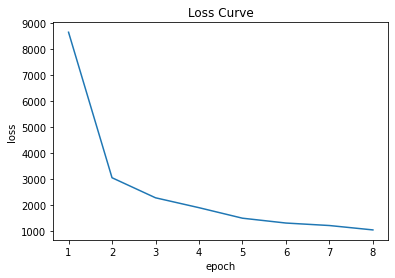

In [14]:
# Create a plot to visualize our loss over time
plt.title("Loss Curve")
plt.plot(range(1, epochs+1), losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### Final Remarks
Our model is pretty descent. More optimizations can be put in place, but for now, this model is a nice model. Our final accuracy is in its 80s. It seems like our model is about to converge.